### Example for Pycon 2019

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14744429779498874477
]


### Open list of voice files

In [3]:
import pandas as pd
path="/Users/cesar.osorio/Documents/pycon/"
df=pd.read_csv(path+"voice_data.csv")
df

,file_name,firstname,lastname,language,raptor
0,kyle3_1.wav,Kyle,Lowry,english,yes
1,kyle4_1.wav,Kyle,Lowry,english,yes
2,pascal2_1.wav,Pascal,Siakam,english,yes
3,pascal3_2.wav,Pascal,Siakam,english,yes
4,marc2_1.wav,Marc,Gasol,english,yes
5,kawhi1_1.wav,Kawhi,Leonard,english,no
6,fred1_1.wav,Fred,VanVleet,english,yes
7,norman1_2.wav,Norman,Powell,english,yes
8,jeremy1_2.wav,Jeremy,Lin,english,no
9,kevinsmith1_1.wav,Kevin,Smith,english,no


### Open WAV files and create "length" variable 

In [11]:
import io
import numpy as np
from scipy.io import wavfile


for f in df.file_name.tolist():
    rate, signal = wavfile.read(path+f)
    df.loc[(df.file_name==f),'length']= np.round(signal.shape[0]/rate,2)

In [12]:
df

,file_name,firstname,lastname,language,raptor,length
0,kyle3_1.wav,Kyle,Lowry,english,yes,128.02
1,kyle4_1.wav,Kyle,Lowry,english,yes,134.43
2,pascal2_1.wav,Pascal,Siakam,english,yes,73.67
3,pascal3_2.wav,Pascal,Siakam,english,yes,90.88
4,marc2_1.wav,Marc,Gasol,english,yes,169.34
5,kawhi1_1.wav,Kawhi,Leonard,english,no,182.64
6,fred1_1.wav,Fred,VanVleet,english,yes,164.97
7,norman1_2.wav,Norman,Powell,english,yes,165.67
8,jeremy1_2.wav,Jeremy,Lin,english,no,180.39
9,kevinsmith1_1.wav,Kevin,Smith,english,no,53.50


### Import librosa to show wave plot and Mel Spectrogram

In [33]:
import librosa

audio_path="kyle3_1.wav"
y, sr = librosa.load(path+audio_path, sr=8000)
# sample rate and length
print(sr,len(y), len(y)/sr)

8000 1024150 128.01875


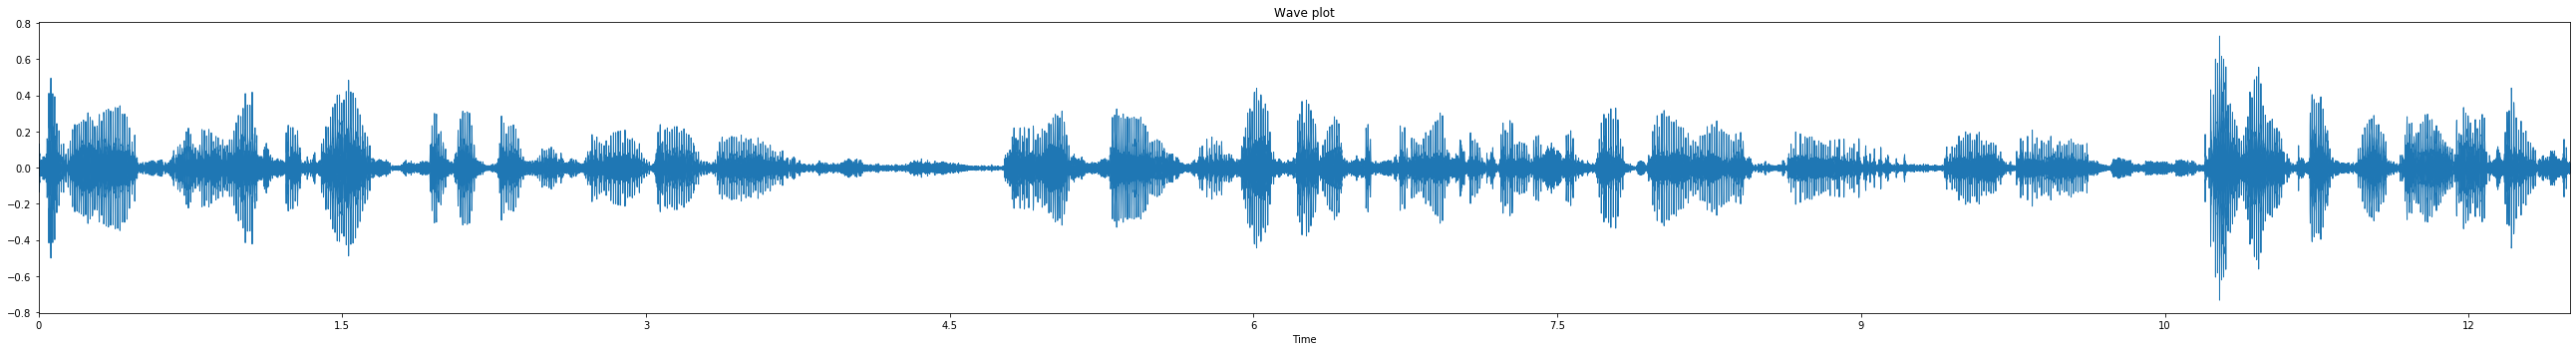

In [45]:
import librosa.display
from matplotlib import pyplot as plt

plt.figure(figsize=(36, 5))
# Put a descriptive title on the plot
plt.title('Wave plot')
librosa.display.waveplot(y[0:100000], sr=sr)
# Make the figure layout compact
plt.tight_layout()

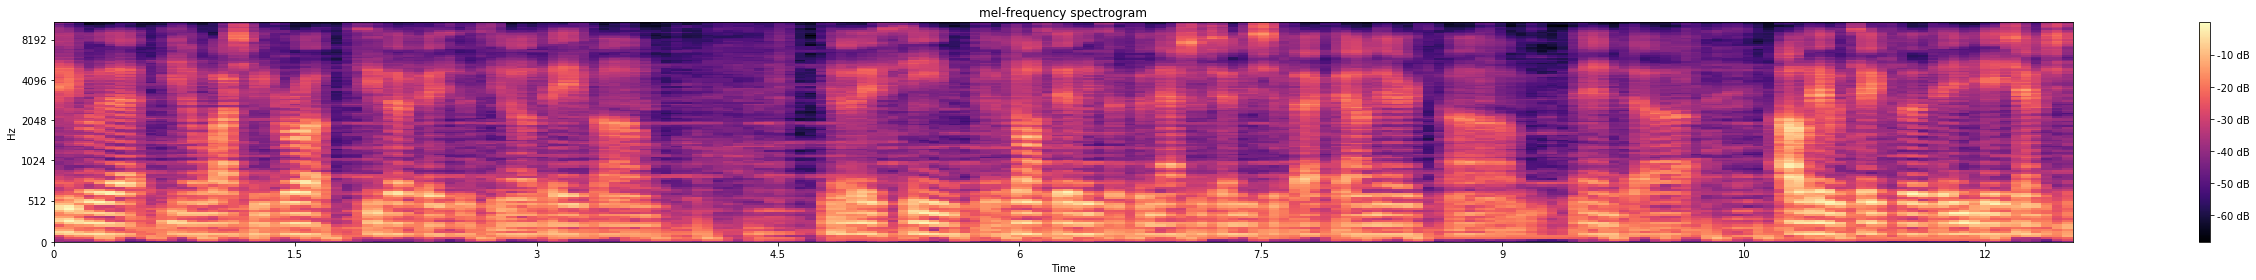

In [44]:
# Let's create and visualiae a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y[0:100000], sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S,  ref=np.max)

# Make a figure
plt.figure(figsize=(36,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel-frequency spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

### Make data ready for CNN and run CNN

In [21]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from python_speech_features import mfcc


def build_feat():
    X = []
    y = []
    _min , _max = float('inf'), -float('inf')
    #for _ in tqdm(range(n_samples)):
    for i in range(df.shape[0]):
        file_name = df.file_name[i]
        print(i,file_name)
        rate, wav = wavfile.read(path+file_name)
        label = df.loc[i,'firstname']

        for j in range(int(len(wav)/rate)):
            sample = wav[j*rate:j*rate + config.step*rate]
            X_sample = mfcc(sample, rate, numcep = config.nfeat,
                       nfilt = config.nfilt, nfft=config.nfft)
            _min = min(np.amin(X_sample), _min)
            _max = max(np.amax(X_sample), _max)
            X.append(X_sample)
            y.append(classes.index(label))

    config.min = _min
    config.max = _max
    X, y = np.array(X) , np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    y = to_categorical(y, num_classes  = df['firstname'].nunique())
    return X, y 


def get_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16,(3,3), activation='relu', strides=(1,1),
                    padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),  activation='relu', strides=(1,1),
                    padding='same'))
    model.add(Conv2D(64,(3,3),  activation='relu', strides=(1,1),
                    padding='same')) 
    model.add(Conv2D(128,(3,3),  activation='relu', strides=(1,1),
                    padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(15, activation='softmax'))  #change to match number of unique voices
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='Adam', metrics=['acc'])
    return model

    
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=200, rate=8000, step=1):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = step  

config = Config(mode = 'conv')
classes = list(np.unique(df.firstname))
X, y = build_feat()

y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model = get_conv_model(input_shape)
    
    
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
model.fit(X, y, epochs=13, batch_size=32, shuffle=True, class_weight=class_weight)

0 kyle3_1.wav
1 kyle4_1.wav


/Users/cesar.osorio/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


2 pascal2_1.wav
3 pascal3_2.wav
4 marc2_1.wav
5 kawhi1_1.wav
6 fred1_1.wav
7 norman1_2.wav
8 jeremy1_2.wav
9 kevinsmith1_1.wav
10 serge1_1.wav
11 chris1_1.wav
12 kyle1_1.wav
13 marc1_1.wav
14 norman1_3.wav
15 jeremy1_3.wav
16 chris2_eng_1.wav
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 199, 13, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 199, 13, 32)       4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 199, 13, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 199, 13, 128)      73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 6, 128)        0         
___________

In [22]:
len(y)

1927

In [46]:
df

,file_name,firstname,lastname,language,raptor,length,code
0,kyle3_1.wav,Kyle,Lowry,english,yes,128.02,5
1,kyle4_1.wav,Kyle,Lowry,english,yes,134.43,5
2,pascal2_1.wav,Pascal,Siakam,english,yes,73.67,8
3,pascal3_2.wav,Pascal,Siakam,english,yes,90.88,8
4,marc2_1.wav,Marc,Gasol,english,yes,169.34,6
5,kawhi1_1.wav,Kawhi,Leonard,english,no,182.64,3
6,fred1_1.wav,Fred,VanVleet,english,yes,164.97,1
7,norman1_2.wav,Norman,Powell,english,yes,165.67,7
8,jeremy1_2.wav,Jeremy,Lin,english,no,180.39,2
9,kevinsmith1_1.wav,Kevin,Smith,english,no,53.50,4


### Extract 64-dimension dense layer from CNN 

In [26]:
from tensorflow.keras.models import Model

# Select the dense_1 which is a flatten 64 dimension vector from CNN
# TSNE : embedding high-dimensional data for visualization in a low-dimensional space 
desiredOutput = model.get_layer('dense_1').output
newModel = Model(model.inputs, desiredOutput)
dense_layer_pred=newModel.predict(X)
dense_layer_pred.shape

(1927, 64)

In [27]:
# USE TSNE to show distance between vectors in 2 dimensions. 

import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, perplexity=30,learning_rate=1000, early_exaggeration=1, random_state=1974).fit_transform(dense_layer_pred)
X_embedded.shape

(1927, 2)

In [28]:
df_embedded=pd.DataFrame(X_embedded, columns=["dim0","dim1"])
df_embedded['code']=np.argmax(y, axis=1)

In [29]:
df_embedded.head()

,dim0,dim1,code
0,28.667734,0.516837,5
1,25.003029,-1.965964,5
2,31.659040,-8.562076,5
3,28.788206,-1.566693,5
4,28.555599,-4.784314,5


/Users/cesar.osorio/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


<Figure size 1080x1080 with 0 Axes>

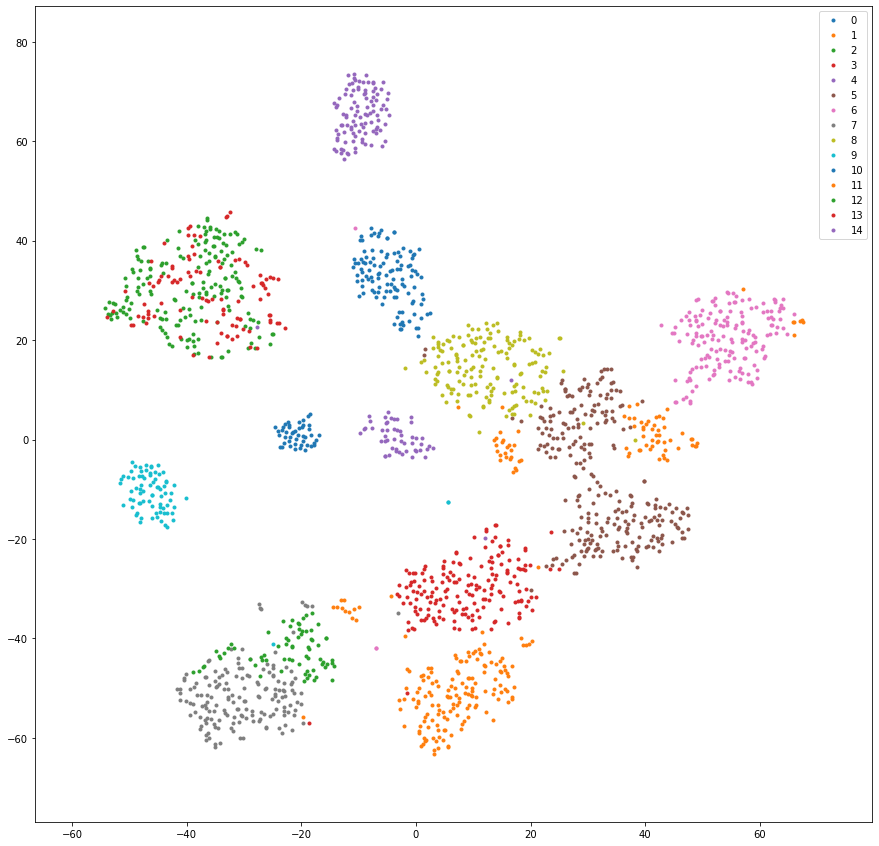

In [48]:
import matplotlib.pyplot as plt
#np.random.seed(1974)
import numpy as np
import pandas as pd

#plt.figure(figsize=(30, 30), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [15, 15]
groups = df_embedded.groupby('code')
#groups = df_embedded.groupby('raptor')  #change to "raptor" to create two groups: raptor or not raptor

# Plot
plt.clf()
fig, ax = plt.subplots()
ax.margins(0.1)
for name, group in groups:
    #print(name)
    ax.plot(group.dim0, group.dim1, marker='o', markersize=3, linestyle='', ms=12, label=name)
    # Add labels to each data point
    #for label, x1, y1 in zip(group.code, group.dim0, group.dim1):
        #plt.annotate(label,xy=(x1, y1), xytext=(0, 0),fontsize=9,textcoords='offset points', ha='right', va='bottom')
ax.legend()

#plt.savefig("version1_3.png")
plt.show()

In [31]:
df['code']=df.firstname.apply(lambda x: classes.index(x))
df

,file_name,firstname,lastname,language,raptor,length,code
0,kyle3_1.wav,Kyle,Lowry,english,yes,128.02,5
1,kyle4_1.wav,Kyle,Lowry,english,yes,134.43,5
2,pascal2_1.wav,Pascal,Siakam,english,yes,73.67,8
3,pascal3_2.wav,Pascal,Siakam,english,yes,90.88,8
4,marc2_1.wav,Marc,Gasol,english,yes,169.34,6
5,kawhi1_1.wav,Kawhi,Leonard,english,no,182.64,3
6,fred1_1.wav,Fred,VanVleet,english,yes,164.97,1
7,norman1_2.wav,Norman,Powell,english,yes,165.67,7
8,jeremy1_2.wav,Jeremy,Lin,english,no,180.39,2
9,kevinsmith1_1.wav,Kevin,Smith,english,no,53.50,4
